In [3]:
import music21
little_star="tinynotation: 4/4 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2 g4 g4 f4 f4 e4 e4 d2 g4 g4 f4 f4 e4 e4 d2 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2"
music21.converter.parse(little_star).show('midi')

In [4]:
import numpy as np

In [5]:
temp = ['c','d','e','f','g','a','b']
note2num = dict(zip(temp,np.arange(1,8)))
num2note =  { value:key for key,value in note2num.items()  }
note2num, num2note

({'c': 1, 'd': 2, 'e': 3, 'f': 4, 'g': 5, 'a': 6, 'b': 7},
 {1: 'c', 2: 'd', 3: 'e', 4: 'f', 5: 'g', 6: 'a', 7: 'b'})

In [6]:
# 시계열 데이터 만들기
def abc2timeseries(s):
    return [ [note2num[i[0]], int(i[1]) ] for i in s.split()[2:] ]
temp = abc2timeseries(little_star)
temp[:5]

[[1, 4], [1, 4], [5, 4], [5, 4], [6, 4]]

In [7]:
def timeseries2abc(t):
    return "tinynotation: 4/4 "+" ".join([num2note[i]+str(j) for i,j in t])
timeseries2abc(temp) 

'tinynotation: 4/4 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2 g4 g4 f4 f4 e4 e4 d2 g4 g4 f4 f4 e4 e4 d2 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2'

In [8]:
# 원핫 코드로 변환하는 표
#[  [1,2],[2,2],..[7,2], ]
onehot = [[i,2] for i in range(1,8)] + [[i,4] for i in range(1,8)] + [[i,8] for i in range(1,8)]

In [9]:
seq = abc2timeseries(little_star)
seq[:5]

[[1, 4], [1, 4], [5, 4], [5, 4], [6, 4]]

In [10]:
# 시계열 데이터 만들기
w = 8  # 윈도우 크기
h = 1  # 수평 계수
def seq2dadtaset(seq,w,h):
    x,y = [],[]
    for i in range(len(seq)-(w+h)+1):        
        x.append(seq[i:(i+w)])
        y.append(seq[i+w+h-1])
    return np.array(x), np.array(y)

In [11]:
X,Y = seq2dadtaset(seq,w,h)
print(X.shape, Y.shape)
print(X[0], Y[0])

(34, 8, 2) (34, 2)
[[1 4]
 [1 4]
 [5 4]
 [5 4]
 [6 4]
 [6 4]
 [5 2]
 [4 4]] [4 4]


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
import tensorflow as tf

In [13]:
# 훈련데이터
split = int(len(X)*1.0)  # 100% 훈련집합으로 사용
x_train = X[:split]; y_train = Y[:split]

In [14]:
def to_onehot(y):
    t = []
    for i in range(len(y)):
        a = np.zeros(len(onehot))
        a[onehot.index(list(y[i])  )] = 1.0    # 예측이 목적이 아니라 생성이 목적이기 때문에 전체를 훈련집합으로
        t.append(a)
    return np.array(t)

In [15]:
y_train = to_onehot(y_train)
y_train

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [16]:
x_train.shape,y_train.shape,x_train[0].shape

((34, 8, 2), (34, 21), (8, 2))

In [17]:
# 모델 학습
model = Sequential([
    LSTM(units=128,activation='relu',input_shape = x_train[0].shape),  # (8,2)
    Dense(y_train.shape[1],activation='softmax'),  # 출력은 y의 원핫코드의 길이 21    
])

In [18]:
model.compile(loss = tf.keras.losses.categorical_crossentropy,optimizer='Adam',metrics=['acc'])

In [19]:
model.fit(x_train,y_train,epochs=10,batch_size=1)

Epoch 1/10
34/34 [==============================] - 1s 3ms/step - loss: 2.7097 - acc: 0.2059
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 2.2178 - acc: 0.2353
Epoch 3/10
34/34 [==============================] - 0s 4ms/step - loss: 2.0883 - acc: 0.2059
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 1.9918 - acc: 0.2059
Epoch 5/10
34/34 [==============================] - 0s 3ms/step - loss: 1.9343 - acc: 0.2647
Epoch 6/10
34/34 [==============================] - 0s 3ms/step - loss: 1.8268 - acc: 0.3235
Epoch 7/10
34/34 [==============================] - 0s 3ms/step - loss: 1.8264 - acc: 0.2647
Epoch 8/10
34/34 [==============================] - 0s 3ms/step - loss: 1.7709 - acc: 0.3824
Epoch 9/10
34/34 [==============================] - 0s 3ms/step - loss: 1.5916 - acc: 0.4118
Epoch 10/10
34/34 [==============================] - 0s 3ms/step - loss: 1.5297 - acc: 0.3824


In [20]:
new_song = []
for i in range(50):
    idx = np.random.randint( len(x_train))  # 랜덤하게 x_train범위에서 인덱스 설정
    p = model.predict(np.expand_dims(x_train[idx],axis=0),verbose=0)
    new_song.append( onehot[np.argmax(p)])
timeseries2abc(new_song)
music21.converter.parse(timeseries2abc(new_song)).show('midi')

In [21]:
timeseries2abc(new_song)

'tinynotation: 4/4 f4 f4 g4 g4 f4 e4 g4 d4 g4 g4 g4 c2 g4 d4 g4 g4 d4 e4 d4 g4 g4 g4 g4 e4 f4 e4 g4 g4 d4 g4 e4 f4 g4 g4 e4 e4 e4 g4 g4 g4 e4 g4 g4 e4 d4 c2 e4 d4 d4 g4'

In [22]:
# 악보그리기
# https://musescore.org/en/download  다운로드 및 설치
from music21 import converter,environment
score = converter.parse(timeseries2abc(new_song))
environment.set('musescoreDirectPNGPath','C:/Program Files/MuseScore 4/bin/MuseScore4.exe')
score.show('musicxml.png')

In [23]:
# 여러곡 편곡

# 봄나들이
spring_picnic="tinynotation: 4/8 g8 e8 g8 e8 g8 a8 g4 e8 g8 e8 c8 d8 e8 c4 g8 e8 g8 e8 g8 a8 g4 b8 a8 g8 e8 d8 e8 c4"
# 나비야 나비야
butterfly="tinynotation: 2/4 g8 e8 e4 f8 d8 d4 c8 d8 e8 f8 g8 g8 g4 g8 e8 e8 e8 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 e8 f8 g4 g8 e8 e4 f8"

In [24]:
music21.converter.parse(butterfly).show('midi')

In [25]:
# 세 곡을 시계열로 변환하고 결합
list_data = []
for i in [little_star,spring_picnic,butterfly]:
    list_data += abc2timeseries(i)
list_data[:5], np.array(list_data).shape   

([[1, 4], [1, 4], [5, 4], [5, 4], [6, 4]], (115, 2))

In [26]:
X,Y = seq2dadtaset(list_data,w,h)
print(X.shape, Y.shape)
# 훈련데이터
split = int(len(X)*1.0)  # 100% 훈련집합으로 사용
print(split)
x_train = X[:split]; y_train = Y[:split]
print(x_train.shape, y_train.shape)
y_train = to_onehot(y_train)
print(x_train.shape, y_train.shape)
# 모델 설계는 이전형태 그대로 사용하고 학습만 새로운 데이터로 학습
# 모델 학습
model = Sequential([
    LSTM(units=128,activation='relu',input_shape = x_train[0].shape),  # (8,2)
    Dense(y_train.shape[1],activation='softmax'),  # 출력은 y의 원핫코드의 길이 21    
])
model.compile(loss = tf.keras.losses.categorical_crossentropy,optimizer='Adam',metrics=['acc'])
model.fit(x_train,y_train,epochs=10,batch_size=1)

(107, 8, 2) (107, 2)
107
(107, 8, 2) (107, 2)
(107, 8, 2) (107, 21)
Epoch 1/10
107/107 [==============================] - 1s 3ms/step - loss: 2.7258 - acc: 0.2056
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 2.3368 - acc: 0.2804
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 2.3042 - acc: 0.2804
Epoch 4/10
107/107 [==============================] - 0s 3ms/step - loss: 2.2118 - acc: 0.2804
Epoch 5/10
107/107 [==============================] - 0s 3ms/step - loss: 2.1459 - acc: 0.2617
Epoch 6/10
107/107 [==============================] - 0s 3ms/step - loss: 2.1188 - acc: 0.2991
Epoch 7/10
107/107 [==============================] - 0s 3ms/step - loss: 2.0593 - acc: 0.3084
Epoch 8/10
107/107 [==============================] - 0s 3ms/step - loss: 2.0362 - acc: 0.3271
Epoch 9/10
107/107 [==============================] - 0s 3ms/step - loss: 2.0129 - acc: 0.3364
Epoch 10/10
107/107 [==============================] - 0s 2ms/step - loss: 1.

In [27]:
new_song = []
for i in range(50):
    idx = np.random.randint( len(x_train))  # 랜덤하게 x_train범위에서 인덱스 설정
    p = model.predict(np.expand_dims(x_train[idx],axis=0),verbose=0)
    new_song.append( onehot[np.argmax(p)])
print(timeseries2abc(new_song))
music21.converter.parse(timeseries2abc(new_song)).show('midi')

tinynotation: 4/4 f4 e8 d4 e8 f4 e8 g8 e8 e8 g8 e8 e8 g8 e8 g8 f4 f4 e8 c4 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 g4 g8 e8 e8 e8 g8 e8 e8 e8 c4 e8 f4 g8 g4 f4 e8 g8 g4 e8 f4 e8


In [28]:
# 악보그리기
# https://musescore.org/en/download  다운로드 및 설치
from music21 import converter,environment
score = converter.parse(timeseries2abc(new_song))
environment.set('musescoreDirectPNGPath','C:/Program Files/MuseScore 4/bin/MuseScore4.exe')
score.show('musicxml.png')

In [29]:
print(timeseries2abc(new_song))

tinynotation: 4/4 f4 e8 d4 e8 f4 e8 g8 e8 e8 g8 e8 e8 g8 e8 g8 f4 f4 e8 c4 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 g4 g8 e8 e8 e8 g8 e8 e8 e8 c4 e8 f4 g8 g4 f4 e8 g8 g4 e8 f4 e8


In [30]:
# 기타 악보
from music21 import instrument

In [31]:
guitar = instrument.Guitar()
score.insert(0,guitar)
score.write('midi','guitar_score.mid')

'guitar_score.mid'

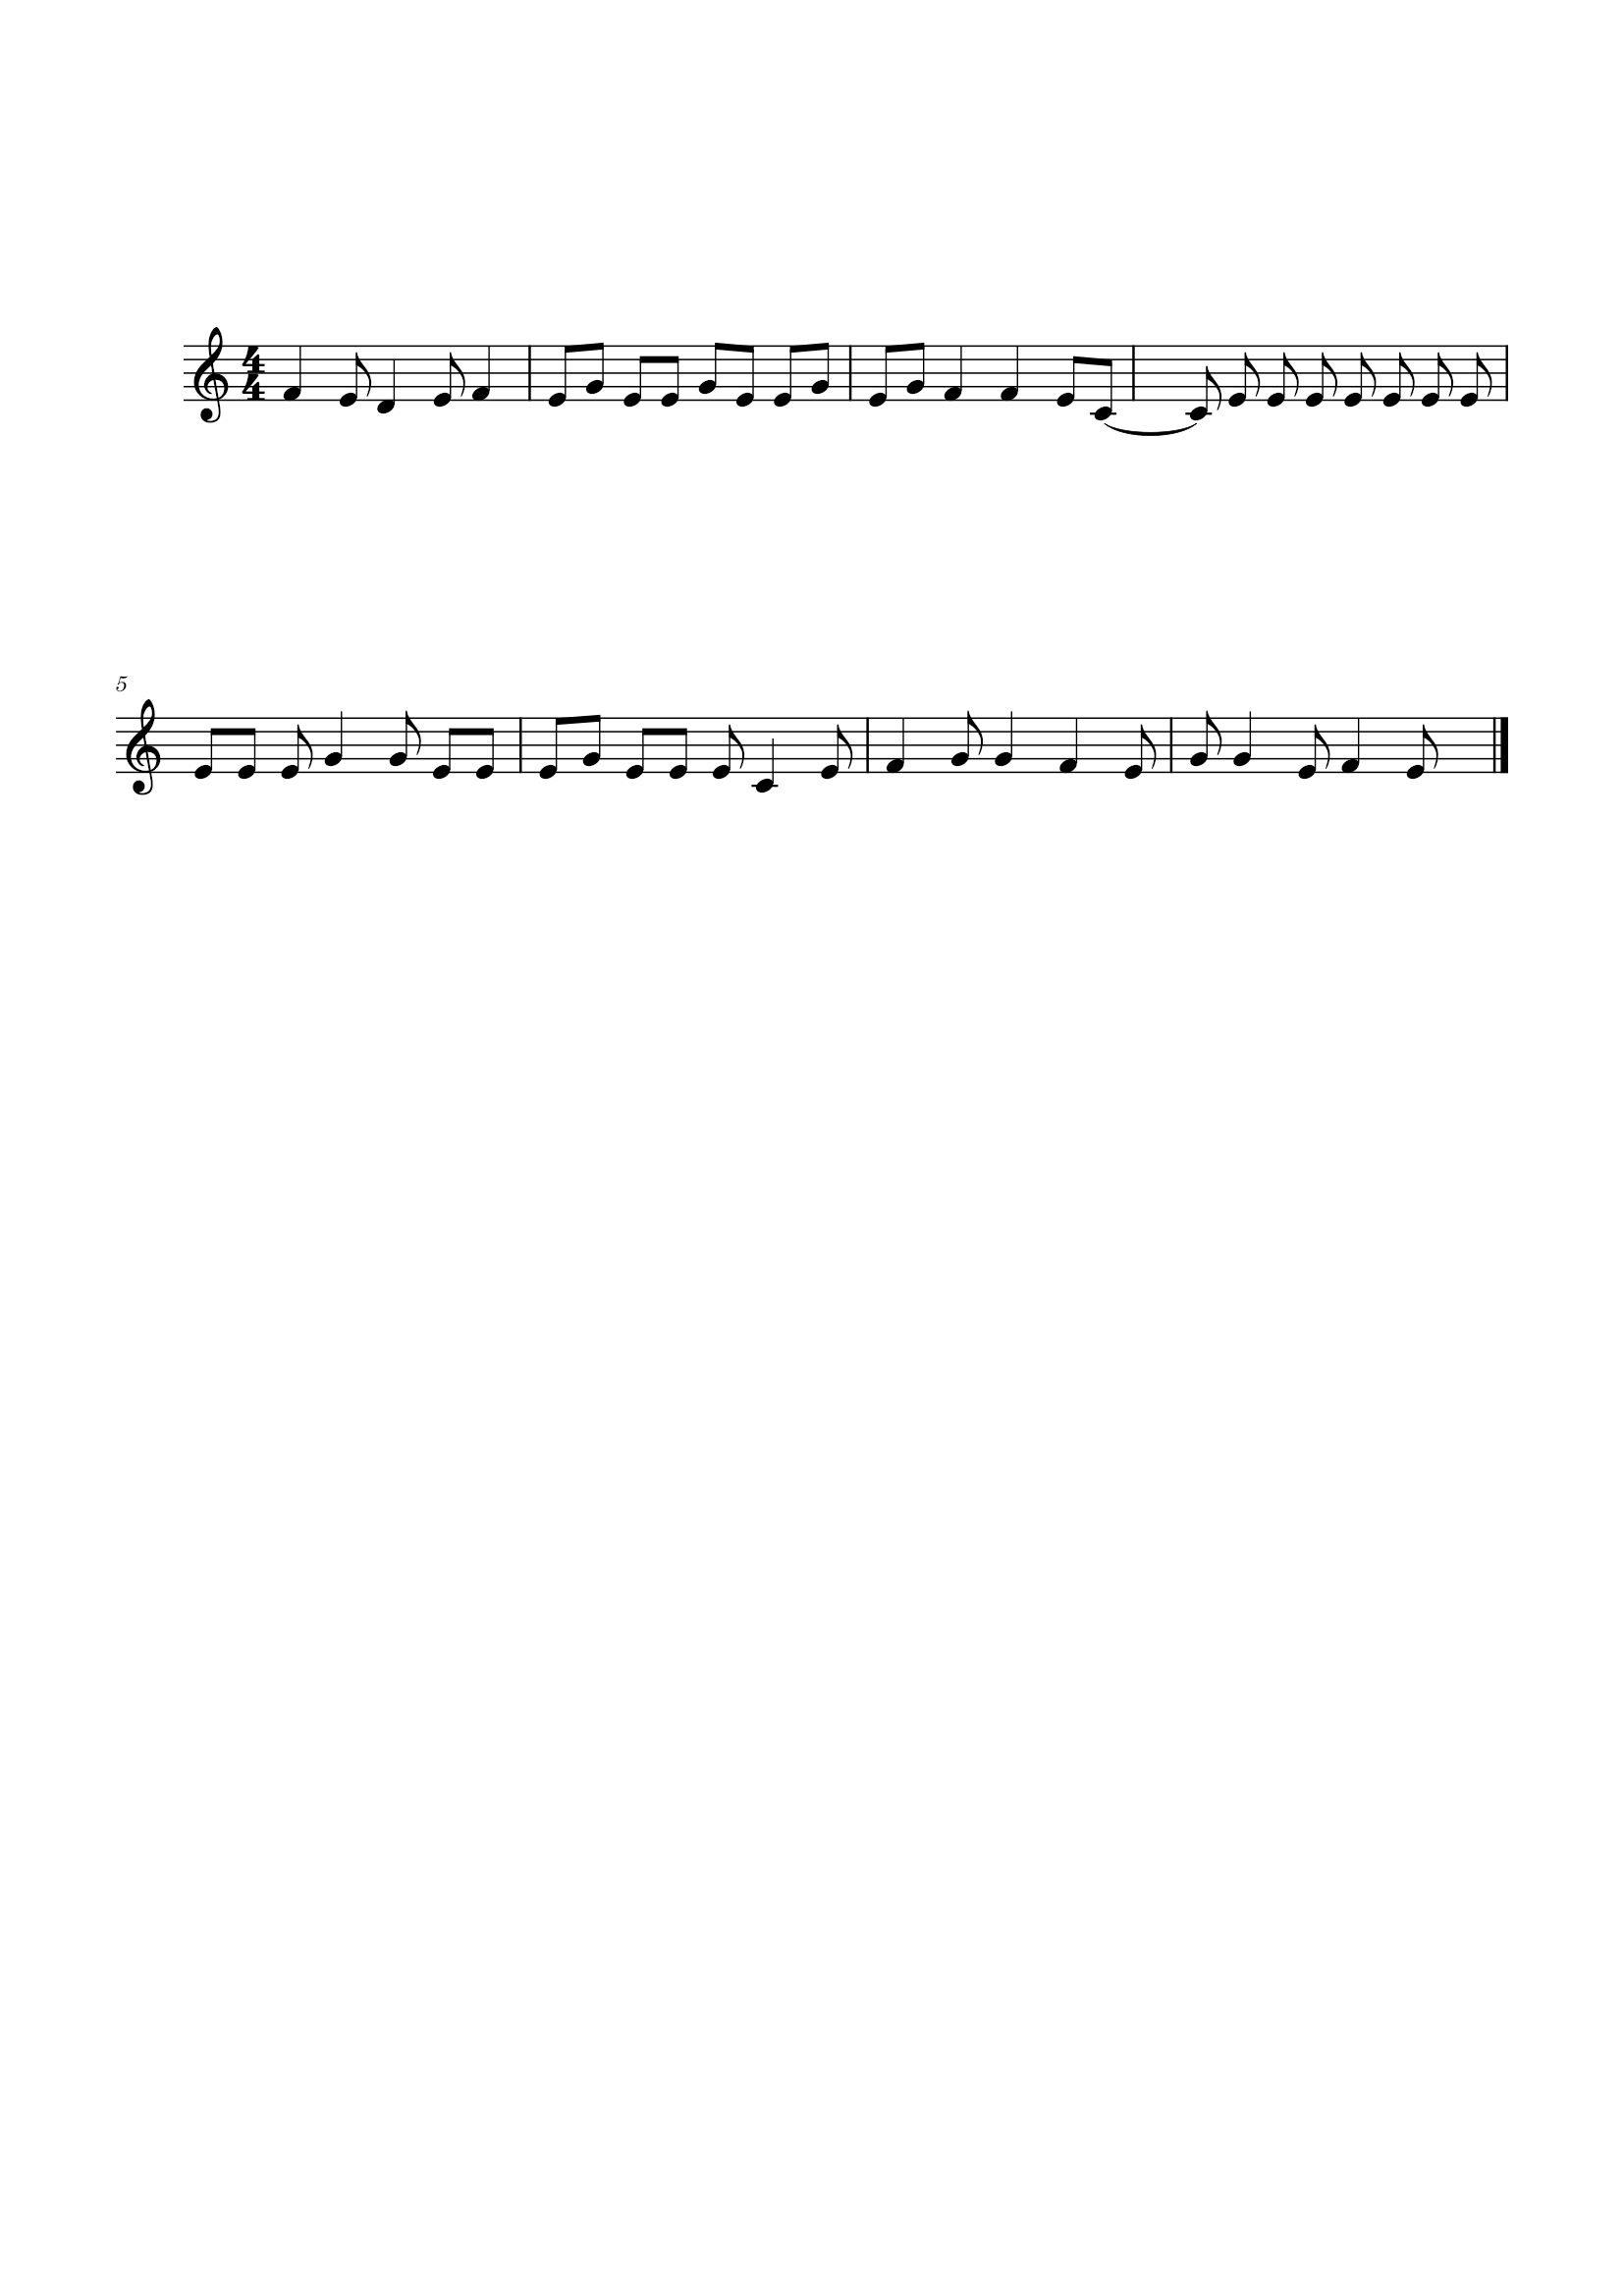

In [32]:
score.show()